# Sample Analysis
Coy Zimmermann
Last updated 8/6/2021

The purpose of this notebook is to run you through a typical analysis of data generated from link.py. Use this as a starting point to retrieve the data you need for your purposes.

I really like [seaborn](https://seaborn.pydata.org/index.html) for plotting data in Python. If there are any plots you want to make, look through the documentation!

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from scipy import signal, fftpack
from scipy.stats import linregress
import glob
import cv2
import trackpy as tp

# Plot defaults
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['figure.figsize'] = 10, 8
sns.set_context('talk', font_scale=1.3)

df = pd.read_csv('linked_results/210806_1141AM.csv')
df.drop(labels=['Unnamed: 0'], inplace=True, axis=1)  # drop unused column

Alright, what's our data look like that we generated from link.py? `df.head()` will display the first 5 columns of our dataframe.

In [37]:
df.head()

,Area,x,y,XM,YM,Major,Minor,Angle,imagejtime,approx_frame,...,particle,dx,dy,time,dv,dv_m,Area_m,dx_m,filename,particle_u
0,38,437.605,101.158,437.605,101.158,7.870,6.148,131.615,5.27,52.7,...,463,0.0950,-0.0140,5.3,0.096026,0.593441,14.513112,0.58710,V1.F5 Select,V1.F5 Select-463
1,45,437.700,101.144,437.700,101.144,8.096,7.077,132.996,5.40,54.0,...,463,0.0810,-0.0735,5.4,0.109377,0.675948,17.186580,0.50058,V1.F5 Select,V1.F5 Select-463
2,45,437.767,101.011,437.767,101.011,8.182,7.003,126.902,5.47,54.7,...,463,0.0735,0.0045,5.5,0.073638,0.455081,17.186580,0.45423,V1.F5 Select,V1.F5 Select-463
3,49,437.847,101.153,437.847,101.153,8.270,7.544,135.000,5.60,56.0,...,463,0.0930,0.0745,5.6,0.119161,0.736413,18.714276,0.57474,V1.F5 Select,V1.F5 Select-463
4,53,437.953,101.160,437.953,101.160,8.916,7.569,137.785,5.67,56.7,...,463,0.0990,-0.0445,5.7,0.108541,0.670786,20.241972,0.61182,V1.F5 Select,V1.F5 Select-463


## Description of columns
* `Area` - area of particle in pix^2 for each point in time
* `x`, `y` - location in pixels. the origin is the top left corner of the video.
* `XM`, `YM` - location in µm.
* `Major`, `Minor` - major and minor axes of the fit ellipse. taken directly from the ImageJ particle analysis. [More information](https://imagej.nih.gov/ij/docs/menus/analyze.html)
* `frame` - frame number
* `particle` - particle number *in the given video*
* `dx`, `dy` - centered difference derivative of position, velocity in pix/frame
* `time` - time in seconds.
* `dv` - magnitude of the velocity in pix/frame, $\sqrt{dx^2 + dy^2}$
* `dv_m` - """ but in µm/s
* `Area_m` - area in microns^2
* `dx_m` - horizontal velocity in µm/s
* `filename` - name of the video
* `particle_u` - identifier for a wheel that is a combination of the `filename` and `particle`. Allows analysis across all videos.

## Time Series Plots


In [38]:
# Example plot, plot velocity over time for each particle
# sns.lineplot(data=df, x='time', y='dv_m', hue='particle_u', legend=False)
# ax = plt.gca()
# # ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
# ax.set(xlabel='Time (s)', ylabel='Velocity (µm/s)')

## Checking trajectories
Its often useful to look at the trajectories overlaid over a frame of the video to see if its working correctly or tracking dust. `video_wheels.py` will generate an entire video, but will take awhile on a slow computer. This next cell will just show a single frame of the video.

In [39]:
def show_trajectories(VIDEO_NAME, FRAME):
    """
    Given the filename of the video and a valid frame, display a frame in the video with trajectories overlaid and annotated.
    """
    
    # video always indexes at 0, it is unaware of any clipping in imagej.
    df_check = df[df['filename'] == VIDEO_NAME]
    f_start, f_end = [df_check['frame'].unique().min(), df_check['frame'].unique().max()]
    chosen_frame_img = FRAME - f_start

    vid_path = f'original_video/{VIDEO_NAME}/*.tif'
    img_names = glob.glob(vid_path)
    loaded_img = cv2.imread(img_names[chosen_frame_img])

    fig, ax = plt.subplots()
    plt.imshow(loaded_img)
    tp.plot_traj(df_check.query(f'frame<={FRAME}'), label=True)

    return fig

#fig = show_trajectories(VIDEO_NAME='05182021_2', FRAME=481)

## FFT
So above you can see that the `df` dataframe we generated from link.py is time series data for every particle. You might notice there is some periodicity in the data.. we can *sometimes* use this to extract a good guess using the finite fourier transform. See `ffttest.ipynb` for the functions and tests for using the FFT to get the rotation rate of a µwheel.

The next cell contains the functions to do this. I really encourage you to walk through this code and try to understand what's going on. This is sometimes tricky and may require some debugging. For example, midway through the function you could ask it to save or return a plot of the actual spectrum, like what is shown in `ffttest.ipynb`.

Also, I've had most success using the `Angle` of the fit ellipse to get a reliable rotation rate. I've found that one period of the `Angle` corresponds to one *half rotation*. However, this may not work for you. One of the arguments to the function is `y`, which is the column of the data it will take the FFT with respect to.

In [40]:
def compute_fft(data, y, particle_u):
    """Compute the finite fourier transform of the chosen particle.  

    Compute the fft using scipy. Use the a detrended column to determine the frequency at which the
    eccentricity of the wheel changes. I used this video for a background on the discrete fourier transform.
    https://www.youtube.com/watch?v=mkGsMWi_j4Q

    Args:
        data: dataframe
        y: column to take the fft with respect to
        particle_u: particle to take the fft of

    Returns:
        Dataframe column containing the fft of y
    """
    data = data[data['particle_u'] == particle_u]  # pull only the data matching input `particle_u`

    num_frames = int(len(data))  # the number of frames, or sample points

    # sample spacing
    spf = data['time'].values[1] - data['time'].values[0]  # seconds per frame

    y = data[y]
    detrend_y = signal.detrend(y)  # Detrend
    fft_particle = fftpack.fft(detrend_y)  # Compute fft.

    t_fi = pd.DataFrame()  # Initialize empty dataframe to store xf and yf columns

    # Actually calculating the FFT (formulas from examples and youtube video)
    t_fi['yf'] = 2.0 / num_frames * np.abs(fft_particle[:num_frames // 2])
    # 'np.abs' computes the magnitude of the complex number. fft_particle[:N//2] selects the first N/2 points.
    # Its multiplied by 2 to account for the mirrored half of the spectrum, then normalized by N.

    t_fi['xf'] = np.linspace(start=0.0, stop=1.0 / (2.0 * spf),
                                num=num_frames // 2)  # The double divison sign is integer division.
    t_fi['particle'] = np.full(len(t_fi), particle_u)

    highest_peak_frequency = t_fi.loc[t_fi['yf'].idxmax(), 'xf']  # pulls out the frequency that corresponds to the highest peak
    return highest_peak_frequency

def batch_fft(data, data_grouped):
    """
    For each particle in the `data` dataframe, run the above compute_fft function, which outputs the frequency which corresponds to the highest peak.
    Take this peak for each particle and combine it with a grouped dataframe.
    """
    temp = []
    for p in data['particle_u'].unique():  # run compute_fft for every particle in the input data
        peak = compute_fft(data=data, y='Angle', particle_u=p)
        temp.append([p, peak])

    # Assemble it all into a dataframe that has a column for particle_u and a column for the frequency guess.
    dfpeaks = pd.DataFrame(temp)
    dfpeaks.rename(columns={0: 'particle_u', 1:'freq_guess'}, inplace=True)
    dfpeaks.set_index('particle_u', inplace=True)

    # Merge with a grouped dataframe. I.E. the dataframe only contains one entry for each particle_u. Most often the mean of each particle over time.
    dfmerge = data_grouped.merge(dfpeaks, on='particle_u')
    dfmerge['omega'] = dfmerge['freq_guess'] * np.pi 

    return dfmerge

# Selecting Wheels

Using the excel file `chosenwheels.xls`, enter particles that you either want to blacklist or whitelist. Specify which type you'd like to use with the `filter_type` keyword argument (kwarg) when calling the function.

In [41]:
dfilter = pd.read_excel('chosenwheels.xls')

In [42]:
def filterwheels(a, b, filter_type="whitelist"):
    """
    Filter dataframe `a` using columns from the filter dataframe `b`. 

    Based on `filter_type`
    """
    if filter_type == "whitelist":
        # Only take particle_u's
        df1 = a[a.particle_u.isin(b.particle_u)]

    elif filter_type == "blacklist":
        # Take everything BUT particle_u's
        df1 = a[~a.particle_u.isin(b.particle_u)]
        
        return df1

    else:
        raise Exception("Invalid filter type. filter_type must be whitelist or blacklist.")

    # Only take the frames specified if not NaN
    # TODO Something in here is removing some of the particles I want
    res = pd.DataFrame()
    for p in df1.particle_u.unique():
        df_sub = df1[df1.particle_u == p]  # create subset dataframe of df1 with only particle_u `p`'s data
        chosen_frames = b[b.particle_u == p]['frames'].values[0]  # extract the `frames` column value from the filter dataframe

        # Extract the chosen frames for the given particle_u `p`
        if str(chosen_frames) != "nan":  # if there's an entry
            first, last = chosen_frames.split(':')  # look at the range

            # convert wildcard ! to the first or last frame
            if first == "!": 
                first = df_sub['frame'].min()
            else:
                first = int(first)
            if last == "!":
                last = df_sub['frame'].max()
            else:
                last = int(last)
        else:  # take all frames
            first = df_sub['frame'].min()
            last = df_sub['frame'].max()

        # Execute the filtering
        clipped = df_sub[df_sub.frame.isin(np.arange(first, last+1))]  # last+1 because arange does not include the last value
        if len(clipped) < 100:
            print(f"Warning: Particle {p} with chosen_frames {first} and {last} is {len(clipped)} frames.")

        res = pd.concat([res, clipped])  # add to result
    
    return res

In [43]:
df_filtered = filterwheels(df, dfilter, filter_type="blacklist")

In [44]:
# df_filtered['particle_u'].unique()

# Grouped Data
Since time series data is a bit messy, we can take each trajectory and take the mean of columns of interest. We expect that the mean of all of the velocity data is the steady-state velocity.

In [45]:
df_grouped = df_filtered.groupby('particle_u')[['dx_m', 'Area_m', 'dv_m', 'Major', 'Minor']].mean()
df_grouped.head()

,dx_m,Area_m,dv_m,Major,Minor
particle_u,,,,,
V1.F5 Select-463,0.248605,19.547565,0.371494,8.681636,7.483182
V1.F5 Select-562,0.104572,18.854985,0.314200,8.563000,7.335368


In [46]:
df_grouped.describe()

,dx_m,Area_m,dv_m,Major,Minor
count,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.176588,19.201275,0.342847,8.622318,7.409275
std,0.101846,0.489728,0.040513,0.083889,0.104520
min,0.104572,18.854985,0.314200,8.563000,7.335368
25%,0.140580,19.028130,0.328523,8.592659,7.372322
50%,0.176588,19.201275,0.342847,8.622318,7.409275
75%,0.212596,19.374420,0.357170,8.651977,7.446228
max,0.248605,19.547565,0.371494,8.681636,7.483182


Now, using the above FFT functions, we can feed in the time series data in `df` as well as our new grouped dataframe to get a new column for our frequency guess (1/s) and calculated `omega` (radians/s).

In [47]:
dfg = batch_fft(df_filtered, df_grouped)
dfg['filename'] = dfg.index.str.split('-').str[0]
dfg.head()

,dx_m,Area_m,dv_m,Major,Minor,freq_guess,omega,filename
particle_u,,,,,,,,
V1.F5 Select-463,0.248605,19.547565,0.371494,8.681636,7.483182,1.250,3.926991,V1.F5 Select
V1.F5 Select-562,0.104572,18.854985,0.314200,8.563000,7.335368,4.375,13.744468,V1.F5 Select


Lastly, we can add a few columns that are useful for plotting.

In [48]:
CAMBER_ANGLE = 30  # degrees
dfg['area_flat'] = dfg['Area_m'] / np.cos(np.radians(CAMBER_ANGLE))
dfg['R'] = np.sqrt(dfg['area_flat'] / np.pi)

In [49]:
dfg.describe()

,dx_m,Area_m,dv_m,Major,Minor,freq_guess,omega,area_flat,R
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.176588,19.201275,0.342847,8.622318,7.409275,2.812500,8.835729,22.171722,2.656483
std,0.101846,0.489728,0.040513,0.083889,0.104520,2.209709,6.942005,0.565489,0.033880
min,0.104572,18.854985,0.314200,8.563000,7.335368,1.250000,3.926991,21.771861,2.632527
25%,0.140580,19.028130,0.328523,8.592659,7.372322,2.031250,6.381360,21.971792,2.644505
50%,0.176588,19.201275,0.342847,8.622318,7.409275,2.812500,8.835729,22.171722,2.656483
75%,0.212596,19.374420,0.357170,8.651977,7.446228,3.593750,11.290099,22.371653,2.668462
max,0.248605,19.547565,0.371494,8.681636,7.483182,4.375000,13.744468,22.571584,2.680440


# Plotting
Here, we plot the data. Seaborn has a variety of features to allow for great plots. Here I'll walk you through a typical process for plotting according to an experimental condition.

The basic process is using a scatterplot command like:
```
sns.scatterplot(data=dfg, x='R', y='dv_m', edgecolor='k', hue='filename', alpha=0.7)
```

By using the `hue` parameter, we can show a third variable in our scatterplot. Here I'll name the column I'd like to use and Seaborn will do the rest.

See this tutorial (https://pandas.pydata.org/docs/getting_started/intro_tutorials/10_text_data.html) to figure out how to extract experimental conditions from the filename into a new column.

[Text(0.5, 0, 'R (µm)'), Text(0, 0.5, 'Velocity (µm/s)')]

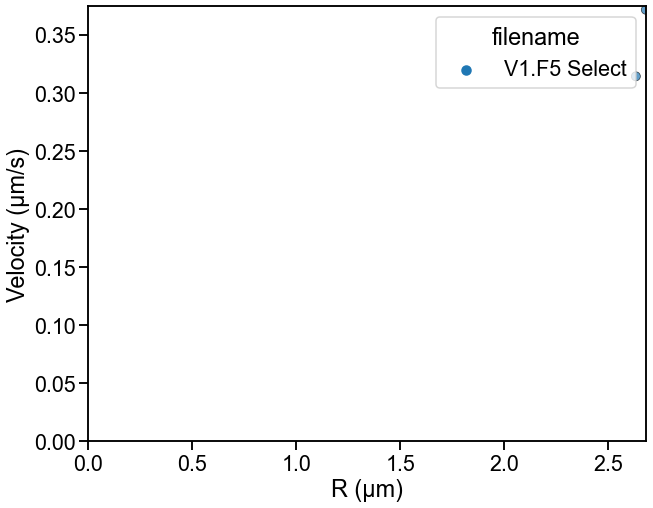

In [50]:
sns.scatterplot(data=dfg, x='R', y='dv_m', edgecolor='k', hue='filename', alpha=0.7)
ax = plt.gca()
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set(xlabel="R (µm)", ylabel="Velocity (µm/s)")

# uncomment this to save the figure
# plt.savefig('plotnamehere.png', dpi=400)

[Text(0.5, 0, 'Mean µWheel Velocity (µm)')]

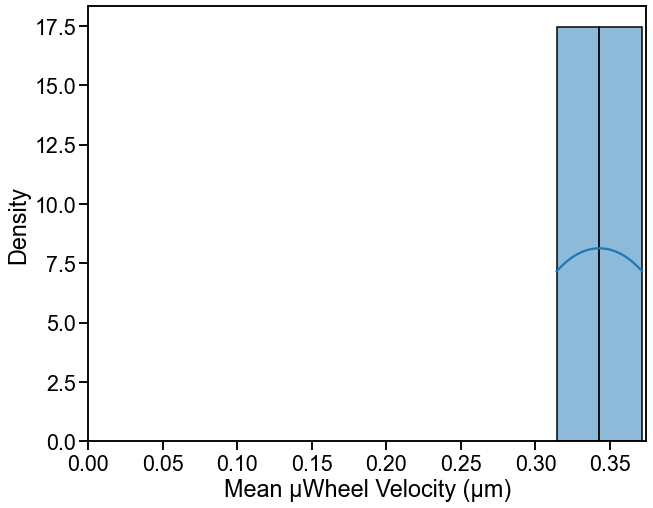

In [51]:
sns.histplot(data=dfg, x='dv_m', kde='True', stat='density', common_norm=False)
ax = plt.gca()
ax.set_xlim(left=0)
ax.set(xlabel='Mean µWheel Velocity (µm)')

[Text(0.5, 0, 'R (µm)'), Text(0, 0.5, 'ω (1/s)')]

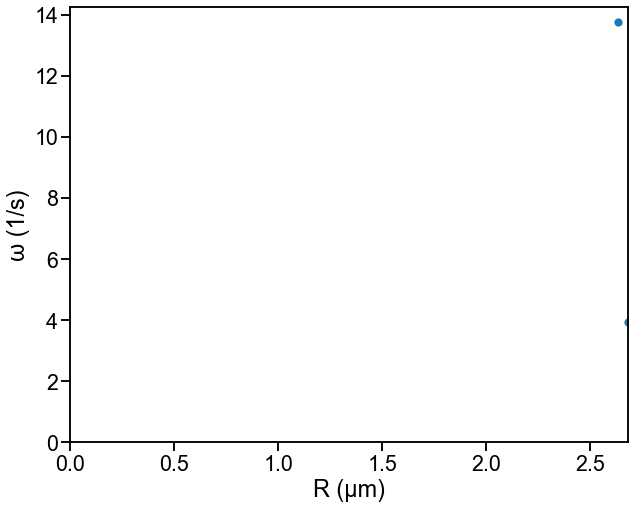

In [52]:
sns.scatterplot(data=dfg, x='R', y='omega')
ax = plt.gca()
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set(xlabel="R (µm)", ylabel="ω (1/s)")